Чат бот с вниманием.



#Добро пожаловать на задание уровня Pro.

В данном задании требуется на базе для чат-бота сравнить модель seq2seq и seq2seq с вниманием

Успехов!

In [ ]:
# модуль для загрузки файлов в colab
from google.colab import files 

# Подключим tensorflow
import tensorflow as tf 

# Импортируем слои
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention

# Импортируем модели
from tensorflow.keras.models import Sequential, Model, load_model

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Используем метод для формирования последовательностей одинаковой длины
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# Импортируем оптимизаторы
from tensorflow.keras.optimizers import RMSprop, Adam

# Подключим функцию потерь
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Подключим numpy - библиотеку для работы с массивами данных
import numpy as np 

# Импортируем pandas
import pandas as pd

# Подключим библиотеку для визуализации данных
import matplotlib.pyplot as plt 

# Подключим модуль для определения форматирования и местоположения делений на осях графиков
import matplotlib.ticker as ticker 

# Подключим модуль для разбивки данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split 

# Импортируем методы для отображения модели и преобразования в ОНЕ
from tensorflow.keras.utils import to_categorical, plot_model

# Подключим модуль для работы с регулярными выражениями
import re 

# Подключим модуль для работы с временем
import time

# Подключим модуль для работы с операционной системой
import os 

import gdown

In [ ]:
# Подключаем диск
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt', None, quiet=True)

'9kdialogs.txt'

In [ ]:
# Определим переменную с именем файла с датасетом
path_to_file="9kdialogs.txt"

In [ ]:
with open(path_to_file, 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines = f.read().split('\n')                  # Читаем весь файл, режем на строки

In [ ]:
print(lines[0:10])

['- - Как вы можете быть таким уверенным?', '- Элементарно.', '', '- - А что делать будем?', '- Ждать.', '- - Надеюсь, не до первой звезды?', '- Я тоже на это надеюсь.', '', '- - За что?', '- Вы знаете за что!']


Sequence to sequence

In [ ]:
def my_replacer(s):  

    ''' Функция для удаления пробелов перед знаками препинания

        Args: строка или список строк

        Returns: строка или список строк
    '''

    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace('- ','').replace('- ','').replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace('- ','').replace('- ','').replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')) # Убираем перед знаками препинания пробел и возвращаем


        # Вернем список строк
        return ou   

Создание выборки.

In [ ]:
# Цикл по строкам
PrevLine=''
Questions=[]
Answers=[]
for i,line in enumerate(lines):
    
    if i>0 and line!='' and PrevLine!='':
      Questions.append(my_replacer(PrevLine))
      Answers.append(my_replacer(line))
    PrevLine=line

In [ ]:
print(Questions[:4],Answers[:4])

['Как вы можете быть таким уверенным?', 'А что делать будем?', 'Ждать.', 'Надеюсь, не до первой звезды?'] ['Элементарно.', 'Ждать.', 'Надеюсь, не до первой звезды?', 'Я тоже на это надеюсь.']


In [ ]:
Answers_SE = ['<START> ' + s + ' <END>' for s in Answers]
#Questions_SE = ['<START> ' + s + ' <END>' for s in Questions]

In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(Questions + Answers_SE)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))             

Фрагмент словаря : [('start', 1), ('end', 2), ('не', 3), ('что', 4), ('а', 5), ('ты', 6), ('в', 7), ('я', 8), ('вы', 9), ('это', 10), ('и', 11), ('как', 12), ('на', 13), ('у', 14), ('с', 15), ('где', 16), ('да.', 17), ('нет.', 18), ('кто', 19), ('он', 20), ('что?', 21), ('так', 22), ('же', 23), ('все', 24), ('то', 25), ('ну', 26), ('да', 27), ('за', 28), ('мне', 29), ('да,', 30), ('нет,', 31), ('мы', 32), ('тебя', 33), ('тебе', 34), ('чего', 35), ('что,', 36), ('вас', 37), ('меня', 38), ('вам', 39), ('еще', 40), ('куда', 41), ('ну,', 42), ('по', 43), ('она', 44), ('его', 45), ('знаю.', 46), ('это?', 47), ('чем', 48), ('может,', 49), ('к', 50)]
Размер словаря : 16759


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenized_Questions = tokenizer.texts_to_sequences(Questions)
tokenized_Answers_SE = tokenizer.texts_to_sequences(Answers_SE)

# Уточняем длину самой длинной фразы
maxLen_Questions = max([ len(x) for x in tokenized_Questions])
maxLen_Answers_SE = max([ len(x) for x in tokenized_Answers_SE])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
padded_Questions = np.array(pad_sequences(tokenized_Questions, maxlen=maxLen_Questions, padding='post'))
padded_Answers_SE = np.array(pad_sequences(tokenized_Answers_SE, maxlen=maxLen_Answers_SE, padding='post'))


for i in range(len(tokenized_Answers_SE)) :                  # Для разбитых на последовательности ответов
    tokenized_Answers_SE[i] = tokenized_Answers_SE[i][1:]          # Избавляемся от тега <START>
padded_Answers_E = np.array(pad_sequences(tokenized_Answers_SE, maxlen=maxLen_Answers_SE, padding='post'))


# Выведем на экран
print('Пример оригинального текста: {}'.format(Answers_SE[100])) 
print('Пример eng                         : {}'.format(padded_Answers_SE[100]))         
print('Пример eng SE                         : {}'.format(padded_Answers_E[100]))


Пример оригинального текста: <START> Здесь, здесь. <END>
Пример eng                         : [  1 654 150   2   0   0   0   0   0   0   0   0   0   0]
Пример eng SE                         : [654 150   2   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
# Создадим энкодер 

encoderInputs_t1 = Input(shape=(None , ))                                             # Добавим входной слой
encoderEmbedding_t1 = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs_t1)  # Добавим эмбеддинг
encoderOutputs_t1, state_h_t1 , state_c_t1 = LSTM(200, return_state=True)(encoderEmbedding_t1) # Добавим LSTM
encoderStates_t1 = [state_h_t1, state_c_t1]                                                 # Соберем выходы lstm  в список    

In [ ]:
# Создадим декодер 

decoderInputs_t1 = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding_t1 = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs_t1)    # Добавим эмбеддинг

decoderLSTM_t1 = LSTM(200, return_state=True, return_sequences=True)
#decoderOutputs = decoderLSTM1 (decoderEmbedding, initial_state=encoderStates)
decoderOutputs_t1 , _ , _ = decoderLSTM_t1 (decoderEmbedding_t1, initial_state=encoderStates_t1) # Прогоним выход embedding через LSTM
decoderDense_t1 = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output_t1 = decoderDense_t1 (decoderOutputs_t1)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
# Собираем модель

model_1LSTM = Model([encoderInputs_t1, decoderInputs_t1], output_t1)
model_1LSTM.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')
print(model_1LSTM.summary()) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    3351800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    3351800     ['input_2[0][0]']                
                                                                                              

In [ ]:
model_1LSTM.fit([padded_Questions , padded_Answers_SE], padded_Answers_E, batch_size=256, epochs=100) 

Epoch 1/100
42/42 [==============================] - 13s 51ms/step - loss: 2.3692
Epoch 2/100
42/42 [==============================] - 2s 48ms/step - loss: 1.9137
Epoch 3/100
42/42 [==============================] - 2s 48ms/step - loss: 1.7776
Epoch 4/100
42/42 [==============================] - 2s 48ms/step - loss: 1.6989
Epoch 5/100
42/42 [==============================] - 2s 48ms/step - loss: 1.6488
Epoch 6/100
42/42 [==============================] - 2s 49ms/step - loss: 1.6084
Epoch 7/100
42/42 [==============================] - 2s 48ms/step - loss: 1.5750
Epoch 8/100
42/42 [==============================] - 2s 49ms/step - loss: 1.5458
Epoch 9/100
42/42 [==============================] - 2s 50ms/step - loss: 1.5192
Epoch 10/100
42/42 [==============================] - 2s 49ms/step - loss: 1.4941
Epoch 11/100
42/42 [==============================] - 2s 49ms/step - loss: 1.4690
Epoch 12/100
42/42 [==============================] - 2s 49ms/step - loss: 1.4446
Epoch 13/100
42/42 [====

In [ ]:
# Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
chat_encoderModel_1LSTM = Model(encoderInputs_t1, encoderStates_t1) 

decoderStateInput_h_1LSTM = Input(shape=(200 ,)) # Добавим входной слой для state_h
decoderStateInput_c_1LSTM = Input(shape=(200 ,)) # Добавим входной слой для state_c
decoderStatesInputs_1LSTM = [decoderStateInput_h_1LSTM, decoderStateInput_c_1LSTM] 
chat_decoderOutputs_1LSTM, chat_state_h_1LSTM, translate_state_c_1LSTM = decoderLSTM_t1(decoderEmbedding_t1, initial_state=decoderStatesInputs_1LSTM) 
chat_decoderStates_1LSTM = [chat_state_h_1LSTM, translate_state_c_1LSTM]            
chat_decoderOutputs_1LSTM = decoderDense_t1(chat_decoderOutputs_1LSTM) 
chat_decoderModel_1LSTM = Model([decoderInputs_t1] + decoderStatesInputs_1LSTM, [chat_decoderOutputs_1LSTM] + chat_decoderStates_1LSTM)



In [ ]:
def strToTokens(sentence: str):      

    ''' Функция для удаления пробелов перед знаками препинания

        Args: фраза

        Returns: список токенов
    '''

    # Почистим фразу
    tmp_sent = my_replacer(sentence)  
    
    # Приведем предложение к нижнему регистру и разбирает на слова
    words = tmp_sent.lower().split()  
    #print(words)
    # Создадим список для последовательности токенов/индексов
    tokensList = list()               

    # Для каждого слова в предложении
    for word in words:
        
        try:
            tokensList.append(tokenizer.word_index[word]) # Определяем токенайзером индекс и добавляем в список
        except:
            pass # Слова нет - просто игнорируем его

    # Вернёт входную фразу в виде последовательности индексов
    if tokensList:
        return pad_sequences([tokensList], maxlen=maxLen_Questions , padding='post')

    # Фраза из незнакомых слов - вернем None 
    return None

In [ ]:
import numpy as np
emptyTargetSeq = np.zeros((1, 1))


emptyTargetSeq[0, 0] = 5

emptyTargetSeq

array([[5.]])

In [ ]:
import random
def ChatAnswer(Sentence):
  qua  = strToTokens(Sentence)
  if qua is None:                                      
    return None
  LastWord = np.zeros((1, 1))                    
  LastWord[0, 0] = tokenizer.word_index['start'] 
  stopCondition = False                                
  decodedTranslation = '' 
  statesValues = chat_encoderModel_1LSTM.predict(qua)                              

  # пока не сработало стоп-условие
  while not stopCondition:                             
        # В модель декодера подадим пустую последовательность со словом 'start' и состояния
        decOutputs , h , c = chat_decoderModel_1LSTM.predict([LastWord] + statesValues)
        #print(np.shape(decOutputs),np.shape(h),np.shape(c))
        # Получим индекс предсказанного слова.
        #print(decOutputs[0, 0, :].shape[0])
        #print(random.choices(np.array(range(decOutputs[0, 0, :].shape[0])), weights=decOutputs[0, 0, :]))
        
        sampledWordIndex = random.choices(np.array(range(decOutputs[0, 0, :].shape[0])), weights=decOutputs[0, 0, :])[0]
        #print(sampledWordIndex)
        # Создаем переменную для преобразованных на естественный язык слов
        sampledWord = None                                 

        # Переберем в цикле все индексы токенайзера
        for word, index in tokenizer.word_index.items():
        
          # Если индекс выбранного слова соответствует какому-то индексу из словаря
          if (sampledWordIndex == index):
            # Выбранное слово фиксируем в переменную sampledWord
            sampledWord = word                       
            if(sampledWord != 'end'):
              # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
              decodedTranslation += ' {}'.format(word) 
            
        
        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
        if sampledWord == 'end' or len(decodedTranslation.split()) > maxLen_Answers_SE:
          stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

        # Создаем пустой массив
        LastWord = np.zeros((1, 1))       
        
        # Заносим в него индекс выбранного слова
        LastWord[0, 0] = sampledWordIndex 
        
        # Записываем состояния, обновленные декодером 
        statesValues = [h, c]   
  return decodedTranslation

Сам с собой чатится

In [ ]:
StartSentnce=Questions[100]
print(StartSentnce)
for i in range(0,200):
  StartSentnce=ChatAnswer(StartSentnce)
  print(StartSentnce)

Ну где ты там?
 потому что видите.
 я тоже это чувствую.
 конечно.
 очередь.
 за же так нибудь ли я если едет было от тебе куклу.
 нет. я карандашей.
 да.
 странно.
 он приходил у меня невозможное.
 если я буду но но тоже с последний раз?
 с удовольствием.
 подавать горячее?
 да, пожалуйста.
 сейчас пожалуйста.
 зачем?
 чтобы к шести?
 да!
 тогда выйдите и вернитесь на свое место.
 да, сейчас!
 ну, мне минералочки.
 других надо, чтобы что очень...
 бога лет.
 и вон то? вроде же!
 хотим вам есть?
 только на подобрала, в того .
 какое?
 вот тот самое.
 да, вот немного.
 да... я хорошо бы вон
 и совсем помянем найдется!
 ну и нужно о нее два всего!
 да, ничего, есть?
 ну, есть.
 чугунок есть.
 повидать нет, я хочется?
 нет.
 разве здесь правда, не знаете?
 да, ладно...
 да, конечно, с тяжко в жива
 скорее к сядь.
 сегодня в порядке.
 тысяча есть.
 ее. пять до перешли
 да, можешь, мы никого нет.
 а вы на последний нет, поедем, мама.
 из работы.
 все, что же еще?
 николай.
 ну да. у меня и 

In [ ]:
Questions[0:10]

['Как вы можете быть таким уверенным ?',
 'А что делать будем ?',
 'Ждать .',
 'Надеюсь , не до первой звезды ?',
 'За что ?',
 'Ты что нибудь понимаешь ?',
 'Обсудим это завтра , ладно ?',
 'Кто услышит ?',
 'Что если ?',
 'Ну я пойду ?']

С вниманием

In [ ]:
def preprocess_sentence(phrases): # Функция принимает содержимое словаря

  # Разделяем пробелами слова и знаки препинания("А как насчет тебя? " -> "А как насчет тебя ? ") 
  phrases = re.sub(r"([?.!,;:])", r" \1 ", phrases) # r" \1 " берёт значения 1й группы в скобках; обрамляем указанные символы пробелами

  # Заменяем всё на пробелы, за исключением (a-zA-Zа-яёА-ЯЁ?.!,;:)
  phrases = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", phrases) 
  
  # Получаем строку без случайных лишних пробелов в конце фраз(rstrip удаляет с конца строки)
  phrases = phrases.rstrip().strip()      

  # Для нашей модели обозначим тегами начало и конец предложения  
  phrases = '<start> ' + phrases + ' <end>' 

  # Функция возвращает предобработанные фразы
  return phrases 

In [ ]:
  # Разделяем пробелами слова и знаки препинания("А как насчет тебя? " -> "А как насчет тебя ? ") 
  #Questions = [re.sub(r"([?.!,;:])", r" \1 ", s) for s in Questions] # r" \1 " берёт значения 1й группы в скобках; обрамляем указанные символы пробелами
  #Answers = [re.sub(r"([?.!,;:])", r" \1 ", s) for s in Answers] # r" \1 " берёт значения 1й группы в скобках; обрамляем указанные символы пробелами

  # Заменяем всё на пробелы, за исключением (a-zA-Zа-яёА-ЯЁ?.!,;:)
  #Questions = [re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", s) for s in Questions]
  #Answers = [re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", s) for s in Answers]
  #Answers = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", Answers) 
  
  # Получаем строку без случайных лишних пробелов в конце фраз(rstrip удаляет с конца строки)
  #Questions = [s.rstrip().strip()  for s in Questions]#Questions.rstrip().strip()      
  #Answers = [s.rstrip().strip()  for s in Answers]#Answers.rstrip().strip()      
  
  # Для нашей модели обозначим тегами начало и конец предложения  
  #Questions_SE = ['<START> ' + s + ' <END>' for s in Questions]
  #Answers_SE = ['<START> ' + s + ' <END>' for s in Answers]
  Questions_SE = [preprocess_sentence(s) for s in Questions]
  Answers_SE = [preprocess_sentence(s) for s in Answers]
  


In [ ]:
# Создадим мини-функцию, возвращающую максимальную длину тензора
def max_length(tensor): # Функция принимает на вход тензор(фразы в виде последовательности индексов)

  # Вернем значение максимальной длины его элемента 
  return max(len(t) for t in tensor) 

In [ ]:
tokenizer = Tokenizer(filters='')               # Вызываем класс Токенизатор, просим его не удалять символы, которые он удаляет по умолчанию
tokenizer.fit_on_texts(Questions_SE + Answers_SE)                # "скармливаем" ему тексты для обработки и сборки словаря частотности
Answers_tensor = tokenizer.texts_to_sequences(Answers_SE) # Формируем тензоры и токенизатор для английского языка
Questions_tensor = tokenizer.texts_to_sequences(Questions_SE)
Answers_tensor = pad_sequences(Answers_tensor, padding='post')
Questions_tensor = pad_sequences(Questions_tensor, padding='post')

In [ ]:
Questions_SE[1]

'<start> А что делать будем ? <end>'

In [ ]:
max_length_Q = max_length(Questions_tensor)
max_length_A = max_length(Answers_tensor)
max_length=max(max_length_Q,max_length_A)
# Создаем тренировочную и тестовую выборки по формуле 95/5
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(Questions_tensor, Answers_tensor, test_size=0.05)

In [ ]:
# Визуализируем собранные данные

def convert(language_tokenizer,  # Токенайзер
            tensor):             # Список индексов слов
            
  #  Цикл по токенам во фразе
  for t in tensor:  
    if t!=0:                                                        # Если токен не 0. Т.е. не мусор в конце фразы
      print ("%d ----> %s" % (t, tokenizer.index_word[t])) # Выводи токен и соответствующее слово



In [ ]:
print ("Questions")   
convert(tokenizer, input_tensor_train[0])           # Выведем нулевую пару из вопросов
print ()    

print ("Answers")
convert(tokenizer, target_tensor_train[0])         # Выведем нулевую пару из ответов
print ()   
                                                      
print("Questions тренировочная: " , len(input_tensor_train), "фраз; ", "Answers тренировочная: ", len(target_tensor_train), "фраз")# Выведем статистику по обучающей выборке
print("Questions тестовая: ", len(input_tensor_val), "фраз; ", "Answers тестовая: ", len(target_tensor_val), "фраз")               # Выведем статистику по тестовой выборке

Questions
1 ----> <start>
47 ----> может
89 ----> быть
5 ----> ,
6 ----> что
74 ----> нибудь
40 ----> еще
4 ----> ?
2 ----> <end>

Answers
1 ----> <start>
150 ----> больше
45 ----> ничего
7 ----> не
62 ----> надо
3 ----> .
2 ----> <end>

Questions тренировочная:  10088 фраз;  Answers тренировочная:  10088 фраз
Questions тестовая:  531 фраз;  Answers тестовая:  531 фраз


In [ ]:
# Определим постоянные 

BUFFER_SIZE = len(input_tensor_train)                     # Укажем что случайно сэмплировать будем по всей длине обучающейся выборки
BATCH_SIZE = 256                                          # Указываем размер батча
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE     # Укажем количество шагов в одной эпохе
embedding_dim = 2048                                       # Размерность эмбеддинга, векторного пространства
units = 1024                                              # Задаем размер слоя(количество нейронов в слое) 

In [ ]:
# Задаем размер словаря
vocab_size = len(tokenizer.word_index)+1 

# Создаём датасет из массивов Numpy(рус и анг тренировочные фразы) со случайной подачей тренировочных сэмплов в процессе обучения
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Посмотрим на форму примеров полученных батчей

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 19]), TensorShape([256, 22]))

In [ ]:
class Encoder(Model):

  # Конструктор класса 
  def __init__(self, 
               vocab_size,    # Размер словаря
               embedding_dim, # Размер пространсва эмбеддинга
               enc_units,     # Число нейронов в GRU
               batch_sz):     # Размер батча

    super(Encoder, self).__init__()                                   # Даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz                                          # Атрибут возвращает размер батча
    self.enc_units = enc_units                                        # Атрибут возвращает размер слоя в кодировщике
    self.embedding = Embedding(vocab_size, embedding_dim)             # Атрибут эмбеддинга - слой Кераса с размером словаря на входе и с dim=256

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки
    self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  # Метод принимает входную фразу и начальное состояние
  def call(self, 
           x,       # Входная фраза
           hidden): # Начальное энкодера
    x = self.embedding(x) # входящие тензоры преобразовываются в эмбеддинг
    output, state = self.gru(x, initial_state = hidden) #затем пропускаются через GRU и получаем выход + новое состояние

    # Выход сети GRU и состояние на выходе
    return output, state 

  # Создаем метод инициализации состояний на скрытых слоях
  def initialize_hidden_state(self):

    # Вернем тензор из нулей размер батча на размер слоя, итсполбьзуем как начальное состояние энкодера
    return tf.zeros((self.batch_sz, self.enc_units)) 

In [ ]:
# Создадим модель кодировщика по уже заданным параметрам 
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# Подадим в качестве примера какой-то сэмпл(Тензор[64, 12]) на вход Encoder'у и визуализируем, что получим
sample_hidden = encoder.initialize_hidden_state() #инициализируем начальное скрытое состояние

# Даем Encoder'у сэмпл и начальное состояние, и получим выход из сети GRU и состояние на выходе (вызывается метод call класса Encoder)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Размеры выхода из кодировщика: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Размеры скрытого состояния: (batch size, units) {}'.format(sample_hidden.shape))

Размеры выхода из кодировщика: (batch size, sequence length, units) (256, 19, 1024)
Размеры скрытого состояния: (batch size, units) (256, 1024)


In [ ]:
class BahdanauAttention(Model): # Название класса именем создателя механизма Дмитрия Богданова(Bahdanau)

  # Создаем конструктор класса
  def __init__(self, 
               units):                        # Число нейронов 

    super(BahdanauAttention, self).__init__() # Даем возможность использовать и исполнять методы класса-родителя в классе потомке
    self.W1 = Dense(units)                    # Создаем Dense с заданным числом нейронов
    self.W2 = Dense(units)                    # Создаем Dense с заданным числом нейронов
    self.V =  Dense(1)                        # Создаем Dense с числом нейронов =1

  # Метод принимает состояние и выход энкодера ----------------------------------
  
  def call(self, 
           hidden_state, # Состояние энкодера
           values):      # Выход энкодера
    # Форма состояния на скрытом слое (batch_size, hidden size)
    # Форму состояния на каждом такте увеличим до (batch_size, 1, hidden size)
    # Добавляем это для того, чтобы получить оценку
    hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
    #print(hidden_state.shape)
    #print(values.shape)
    #print(hidden_with_time_axis.shape)
    #print(values[1,11,5])
    #print(hidden_with_time_axis[1,0,5])
    # Форма оценки score (размер батча, макс.длина слов на входе, 1), однёрка в конце, чтобы применить self.V
    # До применения self.V оценка была бы (размер батча, макс.длина слов на входе, количество нейронов в слое)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    #print(self.W1(values).shape)
    #print(self.W2(hidden_with_time_axis).shape)
    #print((self.W1(values) + self.W2(hidden_with_time_axis)).shape)
    #print(score.shape)
    
    # К полученной оценке применим Софтмакс, который покажет вероятность полезности от 0 до 1 для каждого слова в фразе для декодера
    # Форма оценки score - (размер батча, макс.длина слов на входе, 1); Софтмакс применяем к оси "макс.длина слов"
    attention_weights = tf.nn.softmax(score, axis=1)
    #print(attention_weights.shape)
    
    # Построим вектор контекста 
    context_vector = attention_weights * values # Веса внимания перемножим со значениями(выхода из кодировщика)
    #print(context_vector.shape)
    # Сумму также применяем по оси "макс.длина слов на входе"
    context_vector = tf.reduce_sum(context_vector, axis=1) # Размеры вектора контекста после суммирования будут (размер батча, размер слоя)
    #print(context_vector.shape)

    # Возвращает вектор контекста и веса внимания
    return context_vector, attention_weights


In [ ]:
# Проверим, как работает слой
attention_layer = BahdanauAttention(10)

# Подадим на вход слою внимания выход из Encodera и его состояние, и получим значение и веса внимания
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Размеры значения внимания: (размер батча, размер слоя) {}".format(attention_result.shape))
print("Размеры весов внимания: (размер батча, длина последовательности, 1) {}".format(attention_weights.shape))

(256, 1024)
(256, 19, 1024)
(256, 1, 1024)
tf.Tensor(-0.029745221, shape=(), dtype=float32)
tf.Tensor(-0.043278717, shape=(), dtype=float32)
(256, 19, 10)
(256, 1, 10)
(256, 19, 10)
(256, 19, 1)
(256, 19, 1)
(256, 19, 1024)
(256, 1024)
Размеры значения внимания: (размер батча, размер слоя) (256, 1024)
Размеры весов внимания: (размер батча, длина последовательности, 1) (256, 19, 1)


In [ ]:
class Decoder(Model):

  # Создадим конструктор класса
  def __init__(self,   
               vocab_size,    # Размер словаря
               embedding_dim, # Размерность пространства эмбеддинга
               dec_units,     # Число нейронов в GRU
               batch_sz):     # Размер батча
    super(Decoder, self).__init__()                       # Даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz                              # Атрибут возвращает размер батча
    self.dec_units = dec_units                            # Атрибут возвращает размер слоя в декодере(кол-во нейронов)
    self.embedding = Embedding(vocab_size, embedding_dim) # Атрибут эмбеддинга - слой Кераса с размером словаря на входе и (dim=256) на выходе

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки    
    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    self.fc = Dense(vocab_size) # Атрибут вызовет полносвязный слой с размером словаря

    self.attention = BahdanauAttention(self.dec_units) #атрибут подключит механизм внимания, описанный ранее


  def call(self, 
           x,           # Начальный токен
           hidden,      # Состояние  энкодера
           enc_output): # Выход энкодера

    # Enc_output размеры (batch_size, max_length, hidden_size - размер батча, макс.длина фраз, разм.скр.слоя)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    #print('Decoder')
    #print(context_vector.shape)
    #print(attention_weights.shape)
    
    # Входящий тензор слова пропускаем через эмбеддинг (получаем размеры batch_size, 1, embedding_dim)
    x = self.embedding(x)
    #print(x.shape)
    
    # Дальше конкатенируем с вектором контекста (получаем размеры batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #print(tf.expand_dims(context_vector, 1).shape)
    #print(x.shape)
    
    # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x)
    #print(output.shape)
    #print(state.shape)

    # Output размеры (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    #print(output.shape)

    # Пропускаем через полносвязный слой
    x = self.fc(output) #output размеры (batch_size, vocab)
    #print(x.shape)

    # Вернем выходную фразу, вектор состояния, веса внимания
    return x, state, attention_weights

In [ ]:
# Проверим работу декодера, подав на вход случайный массив с нужной размерностью
# Создали декодер с параметрами(размер анг.словаря, размерность эмбеддинга, кол-во нейронов, размер батча)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# Подаём на вход случайный массив с нужной размерностью, состояние и выход с кодировщика
sample_decoder_output, _, _ = decoder(tf.random.uniform((256, 1)), sample_hidden, sample_output)
print ('Размер выхода с декодера: (размер батча, размер словаря) {}'.format(sample_decoder_output.shape))

Размер выхода с декодера: (размер батча, размер словаря) (256, 11397)


In [ ]:
# Выбираем оптимайзер Adam
optimizer = Adam()#learning_rate=0.1) 

In [ ]:
# Используем SparseCategoricalCrossentropy, к-я может работать с некатегориальными лейблами
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # Выбираем функцию потерь

def loss_function(real, pred):                       # Запишем функцию потерь, на вход подаем фактический и предсказанный результат
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # Найдем маску, которая уберет нулевые значения индексов в конце фразы
  loss_ = loss_object(real, pred)                    # Фактические и предсказанные результаты передаем в SparseCategoricalCrossentropy и получаем ошибку
  mask = tf.cast(mask, dtype=loss_.dtype)            # Согласуем тип маски с типом потерь
  loss_ *= mask                                      # Накидываем "маску" которая оставит для работы ненулевые значения
  
  # Вернем reduce_mean - среднее любого выбранного тензора
  return tf.reduce_mean(loss_)

In [ ]:
# Сохраняем процесс обучения модели чекпоинтами тензорфлоу

checkpoint_dir = './training_checkpoints'                                               # Даем ссылку на директорию
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")                                # Добавляем префикс "ckpt"
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder) # Сохраняем состояния/показатели оптимизатора и моделей

In [ ]:
@tf.function
def train_step(inp,         # Входная фраза
               targ,        # Точный перевод
               enc_hidden): # Состояния энкодера

  # Создаем переменную, в которую будем записывать ошибку
  loss = 0                             

  # Все операции по вычислению градиента записываются на ленту(tape) и мы получаем к ним доступ
  with tf.GradientTape() as tape:

    # Передаем тензор и начальное состояние в кодировщик и получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Передадим это состояние декодеру
    dec_hidden = enc_hidden

    # Передаем в качестве входа в декодер индекс токена "<start>"
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Техника "Teacher forcing" - подаем предыдущее выходное слово на вход следущего в декодере. Targ.shape[64, 9]

    for t in range(1, targ.shape[1]): #для каждого слова из английской фразы

      # Передаем в обработку декодеру начальный токен, состояние на выходе из кодера, и выход из кодера
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # Получаем от декодера предсказание и обновленное состояние

      # Обновляем ошибку для текущих предсказаний
      loss += loss_function(targ[:, t], predictions)

      # Используем "Teacher forcing"
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Получаем ошибку на батче . Targ.shape[64, 9]. Делим на 9
  batch_loss = (loss / int(targ.shape[1])) 

  # Создаем список переменных, для которых TensorFlow будет вычислять градиенты
  variables = encoder.trainable_variables + decoder.trainable_variables # создаем переменные, для которых TensorFlow будет вычислять градиенты

  # Отслеживаем градиент
  gradients = tape.gradient(loss, variables)

  # Корректируем веса
  optimizer.apply_gradients(zip(gradients, variables))

  # Функция обучения вернет ошибку на батче
  return batch_loss

In [ ]:
EPOCHS = 50 # устанавливаем количество эпох

for epoch in range(EPOCHS): # Цикл по каждой эпохе
  start = time.time() # Запомним время начала эпохи

  progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics=[
                                     'batch_loss','accuracy'], unit_name='batch')        # Создадим индикатор прогресс обучения

  enc_hidden = encoder.initialize_hidden_state() # Задаем начальное состояние на скрытом слое encodera 
  total_loss = 0                                 # Начальное значение итоговой ошибки

  # Для батча, входного и выходного тензора на каждом шаге эпохи
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden) # Передадим в функцию тензоры и состояние в кодировщике, обучим и получим ошибку на батче
    total_loss += batch_loss                       # Добавим ее в итоговую ошибку
    progbar.update(                                # Обновим состояние индикатора обучения
            batch + 1, values=[('batch_loss', batch_loss)])


  # Каждые 10 эпох будем сохранять чекпоинты
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Выведем показатели после каждой эпохи
  print('Эпоха {} Ошибка {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch)) # Выведем номер эпохи и потери
  print('Время на 1 эпоху {} сек'.format(round(time.time() - start), 1))          # Выведем длительность обучения этой эпохи

39/39 [==============================] - 77s 1s/batch - batch_loss: 1.1065
Эпоха 1 Ошибка 1.3449
Время на 1 эпоху 82 сек
39/39 [==============================] - 46s 1s/batch - batch_loss: 0.9152
Эпоха 2 Ошибка 0.9650
Время на 1 эпоху 82 сек
39/39 [==============================] - 46s 1s/batch - batch_loss: 0.8060
Эпоха 3 Ошибка 0.7979
Время на 1 эпоху 46 сек
39/39 [==============================] - 46s 1s/batch - batch_loss: 0.6762
Эпоха 4 Ошибка 0.6538
Время на 1 эпоху 82 сек
39/39 [==============================] - 45s 1s/batch - batch_loss: 0.5668
Эпоха 5 Ошибка 0.5273
Время на 1 эпоху 46 сек
39/39 [==============================] - 46s 1s/batch - batch_loss: 0.4161
Эпоха 6 Ошибка 0.4194
Время на 1 эпоху 46 сек
39/39 [==============================] - 46s 1s/batch - batch_loss: 0.3199
Эпоха 7 Ошибка 0.3311
Время на 1 эпоху 46 сек
39/39 [==============================] - 46s 1s/batch - batch_loss: 0.2655
Эпоха 8 Ошибка 0.2628
Время на 1 эпоху 46 сек
39/39 [=========================

In [ ]:
tokenizer.word_index['<start>']

1

In [ ]:
#import random
def evaluate(sentence):

    # Создаем начальные настройки графика внимания
    attention_plot = np.zeros((max_length, max_length)) 
    #print(sentence)
    # Предобрабатываем предложение
    sentence = preprocess_sentence(sentence).lower()
    #print(sentence)
    
    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]   # Преобразовываем в послед-ть индексов
    inputs = pad_sequences([inputs], maxlen=max_length, padding='post')        # Делаем паддинг
    inputs = tf.convert_to_tensor(inputs)                                          # Конвертируем в тф тензор

    result = ''                                                                    # Сюда запишем результат

    hidden = [tf.zeros((1, units))]                                                # Задаем начальное состояние
    enc_out, enc_hidden = encoder(inputs, hidden)                                  # Передаем его и входной тензор и получаем выход с кодера и состояние

    dec_hidden = enc_hidden                                                        # Состояние кодера передаем в декодер
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Передаем на вход декодеру <start> в виде индекса

    for t in range(max_length):                                               # Идем по макс.длине фраз выходного языка(анг)
        # Прогоняем через декодер входящий тензор, состояние с выхода кодера, выход с кодера
        # Получаем результат предсказания, обновленное состояние, и веса внимания
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Сохраняем веса внимания для графика
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Аргмаксом вытаскиваем предсказанное слово
        predictions_min=np.amin(predictions[0])
        predictions_max=np.amax(predictions[0])
        #print(predictions_min,predictions_max)
        #predictions_w=(np.array(predictions[0])-predictions_min)/(predictions_max-predictions_min)
        #print(predictions_w.shape,np.std(predictions_w))
        predictions_w=np.exp(predictions[0]) / np.sum(np.exp(predictions[0]), axis=0)
        #print(predictions_w.shape,np.std(predictions_w))
        #predictions_w=np.exp(predictions_w) / np.sum(np.exp(predictions_w), axis=0)
        #predictions_w=np.exp(predictions_w) / np.sum(np.exp(predictions_w), axis=0)
        #predictions_w=np.exp(predictions_w) / np.sum(np.exp(predictions_w), axis=0)
        #print(predictions_w.shape,np.std(predictions_w))
        #print(predictions_w[:10])
        #predicted_id = random.choices(np.array(range(predictions_w.shape[0])), weights=predictions_w)
        predicted_id = [np.random.choice(np.arange(predictions_w.shape[0]), p=predictions_w)]
        #print(tf.argmax(predictions[0]).numpy(),tf.argmax(predictions_w).numpy(),predicted_id[0],np.amax(predictions_w),predictions_w[predicted_id[0]])
        #print(predicted_id[0])
        #print(predictions_w[predicted_id[0]])
        predicted_id=predicted_id[0]
        #print(predicted_id[0],predicted_id[1],predicted_id[2])
        #predicted_id = tf.argmax(predictions[0]).numpy()

        # Результат конвертируем из индекса в слово и сохраняем в result = ''
        result += tokenizer.index_word[predicted_id] + ' '

        # Если предсказанное слово - <end>, то останавливаемся, возвращаем результаты, выводим на графике
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # Педсказанное значение подается обратно в модель
        dec_input = tf.expand_dims([predicted_id], 0)

    # Вернем перевод, входную фразу и веса внимания
    return result, sentence, attention_plot

In [ ]:
def plot_attention(attention,           # Веса внимания
                   sentence,            # Исходная фраза
                   predicted_sentence): # Предсказаные перевод
  
    fig = plt.figure(figsize=(10,10))                                   # Зададим размер 
    ax = fig.add_subplot(1, 1, 1)                                       # Добавим 1 картинку
    ax.matshow(attention, cmap='viridis')                               # Нарисуем 2d матрицу
    fontdict = {'fontsize': 14}                                         # Зададим размер надписей
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # Добавим надпись по горизонтальной оси
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)    # Добавим надпись по вертикальной оси
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))               # Зададим форматирование делений на осях графиков
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))               # Зададим форматирование делений на осях графиков
    plt.show()                                                          # Отрисуем изображение

In [ ]:
def translate(sentence): # Функция принимает предложение и выводит результат с визуализацией
    result, sentence, attention_plot = evaluate(sentence)  # Отдадим фразу. Получим перевод, входную фразу,  веса внимания

    print('Входящая фраза: %s' % (sentence))          # Выведем входную фразу 
    print('Предсказанный перевод: {}'.format(result)) # Выведем полученный перевод

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))] # Возьмем весы внимания, только для слов во фразах. Хвосты не смотрим
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))              # Выведем веса внимания

In [ ]:
def ChatAnswer(sentence): # Функция принимает предложение и выводит результат с визуализацией
    result, sentence, attention_plot = evaluate(sentence)  # Отдадим фразу. Получим перевод, входную фразу,  веса внимания
    return result

In [ ]:
# Воспроизведём последний сохранённый чекпоинт
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Карты распределения внимания

Входящая фраза: <start> давайте дружить <end>
Предсказанный перевод: так . <end> 


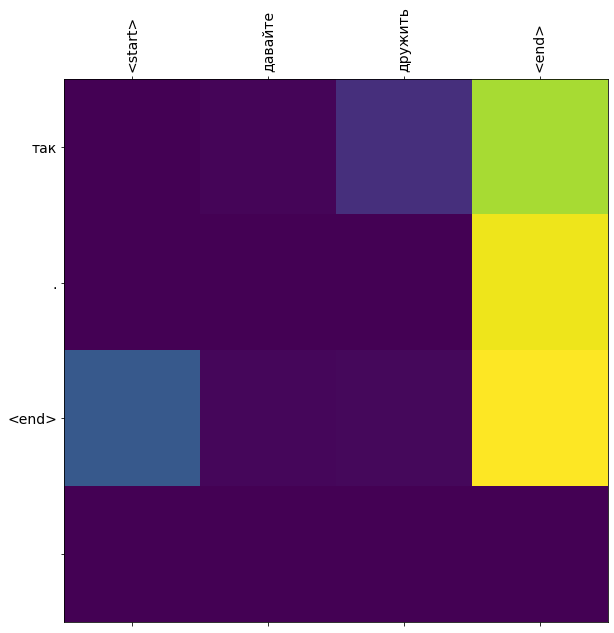

In [ ]:
translate('давайте дружить')

Входящая фраза: <start> у тебя всё хорошо <end>
Предсказанный перевод: я тоже есть десятицентовик . а тебе раз ! <end> 


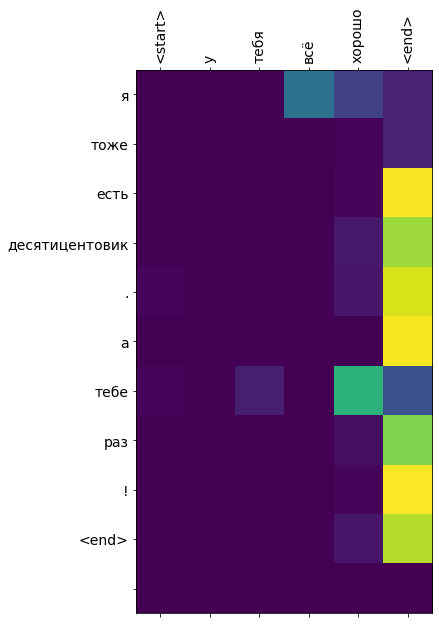

In [ ]:
translate('у тебя всё хорошо')

Входящая фраза: <start> у тебя всё хорошо ? <end>
Предсказанный перевод: я тоже есть десятицентовик . <end> 


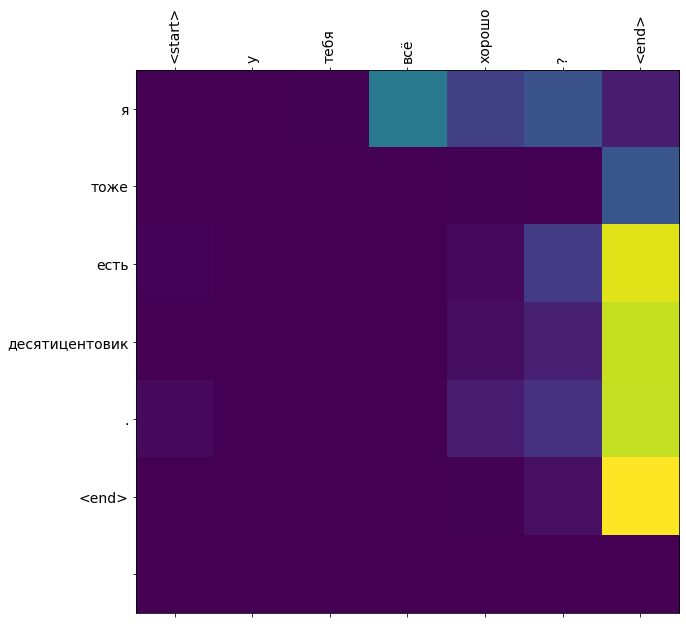

In [ ]:
translate('у тебя всё хорошо?')

Сам с собой.

In [ ]:
StartSentnce=Questions[100]
print(StartSentnce)
for i in range(0,200):
  StartSentnce=Answer(StartSentnce)
  StartSentnce=StartSentnce.replace('<end>', '')
  print(StartSentnce)

Ну где ты там ?
здесь , здесь .  
кто ?  
неважно .  
правда , что ж нет .  
что же не узнаю ?  
днём .  
а не бросите .  
а что ?  
ничего .  
а идти ты можешь ?  
да , здесь .  
а !  
а то выйдите и вас .  
да что ?  
да .  
ну ладно , в другое место перешел .  
куда ?  
опять в карцер .  
я его ж говорил тебе завсегда .  
что это ?  
сейчас разберемся .  
какого такой ?  
я чувствую , вы их отдам .  
благодарю знаешь .  
ты ?  
я .  
не понял . . .  
а мы обе романовы .  
сестры , что ль ?  
однофамилицы .  
паша , разберись .  
а это не хочет ?  
ты об этом делать то немного живы .  
входите или завязали ?  
и не развязывал .  
вообще ?  
вообще . дело в том .  
а вы не погорячились ?  
нет , только .  
хочу к нам ?  
от если будет .  
от меня .  
а надо ?  
может , и надо .  
ладно , вы ?  
думаю , они .  
это уже . . .  
что , плеткой били ?  
это скорее .  
что это хорошо ?  
у нас !  
у кого ?  
нет , забыла . . .  
надо же .  
когда вернешься ?  
не знаю .  
куда же ты поедешь

С человеком

In [ ]:
for i in range(0,200):
  InputSentence=input()
  StartSentnce=ChatAnswer(InputSentence)
  StartSentnce=StartSentnce.replace('<end>', '')
  #print("-"+InputSentence)
  print(StartSentnce)



Зачем?
надо .  
Что надо?
это вам .  
Что мне?
кажется , пожалуйста .  
Спасибо.
да ну ? что ? плакат ? плакат ? что же ты хочешь ? плакат ? что же ты хочешь ? плакат 
Какой плакат?
вы ничего .  
Почему?
тебе не понять , сосунок .  
Да ну.
едем дальше ?  
поехали
а где ?  
что где
а а где ?  
а тут
вот готов .  
ну и хорошо
а вот и прелестно .  


KeyboardInterrupt: ignored

С вниманием более осмыслено, с человеком лучше чем сам с собой.